In [1]:
from datetime import datetime

import numpy as np
import torch
from gym.wrappers import (
    FilterObservation,
    FlattenObservation,
    FrameStack,
    RecordVideo,
    RescaleAction,
    TimeLimit,
)
from stable_baselines3.common.env_util import unwrap_wrapper

from bayesopt import calculate_objective, get_next_samples, scale_action, get_new_bound
from ea_optimize import (
    ARESEADOOCS,
    CallbackList,
    OptimizeFunctionCallback,
    report_ea_optimization_to_logbook,
)
from utils import (
    FilterAction,
    NotVecNormalize,
    PolishedDonkeyCompatibility,
    RecordEpisode,
    send_to_elog,
)


initializing ocelot...


## Preamble

Remarks: I would set a higher max_step for BO, maybe 100/150?

In [2]:
config = config = {
    "action_mode": "direct_unidirectional_quads",
    "gamma": 0.99,
    # "filter_action": [0, 1, 3],
    "filter_action": None,
    "filter_observation": None,
    "frame_stack": None,
    "incoming_mode": "random",
    "incoming_values": None,
    "magnet_init_mode": "constant",
    "magnet_init_values": np.array([10, -10, 0, 10, 0]),
    "misalignment_mode": "constant",
    "misalignment_values": np.zeros(8),
    "n_envs": 40,
    "normalize_observation": True,
    "normalize_reward": True,
    "rescale_action": (-3, 3),
    "reward_mode": "logl1",
    "sb3_device": "auto",
    "target_beam_mode": "constant",
    "target_beam_values": np.zeros(4),
    "target_mu_x_threshold": 1e-5,
    "target_mu_y_threshold": 1e-5,
    "target_sigma_x_threshold": 1e-5,
    "target_sigma_y_threshold": 1e-5,
    "threshold_hold": 5,
    "time_limit": 50000,
    "vec_env": "subproc",
    "w_done": 0.0,
    "w_mu_x": 1.0,
    "w_mu_x_in_threshold": 0.0,
    "w_mu_y": 1.0,
    "w_mu_y_in_threshold": 0.0,
    "w_on_screen": 100.0,
    "w_sigma_x": 1.0,
    "w_sigma_x_in_threshold": 0.0,
    "w_sigma_y": 1.0,
    "w_sigma_y_in_threshold": 0.0,
    "w_time": 0.0,
}


In [3]:
# define a similar optimize function as in ea_optimize.py
from bayesopt import get_new_bound
from ea_optimize import BaseCallback


def optimize(
    target_mu_x,
    target_sigma_x,
    target_mu_y,
    target_sigma_y,
    target_mu_x_threshold=3.3198e-6,
    target_mu_y_threshold=3.3198e-6,
    target_sigma_x_threshold=3.3198e-6,
    target_sigma_y_threshold=3.3198e-6,
    max_steps=100,
    model_name="BO",
    logbook=False,
    callback=BaseCallback(),
    stepsize=0.1,  # comparable to RL env
    obj_function="logmae",
    acquisition="EI",
    init_x=None,
    init_samples=5,
    filter_action=None,
    set_to_best=True,  # set back to best found setting after opt.
):
    # TODO move to an init_callback function
    if callback is None:
        callback = BaseCallback()
    elif isinstance(callback, list):
        callback = CallbackList(callback)

    # Create the environment
    env = ARESEADOOCS(
        action_mode=config["action_mode"],
        magnet_init_mode=config["magnet_init_mode"],
        magnet_init_values=config["magnet_init_values"],
        reward_mode=config["reward_mode"],
        target_beam_mode=config["target_beam_mode"],
        target_beam_values=np.array(
            [target_mu_x, target_sigma_x, target_mu_y, target_sigma_y]
        ),
        target_mu_x_threshold=target_mu_x_threshold,
        target_mu_y_threshold=target_mu_y_threshold,
        target_sigma_x_threshold=target_sigma_x_threshold,
        target_sigma_y_threshold=target_sigma_y_threshold,
        threshold_hold=1,
        w_done=config["w_done"],
        w_mu_x=config["w_mu_x"],
        w_mu_x_in_threshold=config["w_mu_x_in_threshold"],
        w_mu_y=config["w_mu_y"],
        w_mu_y_in_threshold=config["w_mu_y_in_threshold"],
        w_on_screen=config["w_on_screen"],
        w_sigma_x=config["w_sigma_x"],
        w_sigma_x_in_threshold=config["w_sigma_x_in_threshold"],
        w_sigma_y=config["w_sigma_y"],
        w_sigma_y_in_threshold=config["w_sigma_y_in_threshold"],
        w_time=config["w_time"],
    )
    if max_steps is not None:
        env = TimeLimit(env, max_steps)
    if callback is not None:
        env = OptimizeFunctionCallback(env, callback)
    env = RecordEpisode(env)
    if config["filter_observation"] is not None:
        env = FilterObservation(env, config["filter_observation"])
    if config["filter_action"] is not None:
        env = FilterAction(env, config["filter_action"], replace=0)
    env = FlattenObservation(env)
    if config["frame_stack"] is not None:
        env = FrameStack(env, config["frame_stack"])
    if config["rescale_action"] is not None:
        env = RescaleAction(
            env, config["rescale_action"][0], config["rescale_action"][1]
        )
    env = RecordVideo(env, video_folder=f"recordings_real/{datetime.now():%Y%m%d%H%M}")
    # env = NotVecNormalize(env, f"models/{model_name}/vec_normalize.pkl")

    callback.env = env

    # Actual optimisation
    t_start = datetime.now()
    observation = env.reset()
    beam_image_before = env.get_beam_image()
    done = False

    # Initialization
    x_dim = env.action_space.shape[0]
    # bounds = torch.tensor(
    #     np.array([env.action_space.low, env.action_space.high]), dtype=torch.float32
    # )
    if init_x is not None:  # From fix starting points
        X = torch.tensor(init_x.reshape(-1, x_dim), dtype=torch.float32)
    else:  # Random Initialization-5.7934
        action_i = scale_action(env, observation, filter_action)
        X = torch.tensor([action_i], dtype=torch.float32)
        bounds = get_new_bound(env, action_i, stepsize)
        for i in range(init_samples - 1):
            new_action = np.random.uniform(low=bounds[0], high=bounds[1])
            X = torch.cat([X, torch.tensor([new_action])])
    # Sample initial Ys to build GP
    Y = torch.empty((X.shape[0], 1))
    for i, action in enumerate(X):
        action = action.detach().numpy()
        print(f"Collecting initial Ys step {i} at {action = }")
        observation, reward, done, info = env.step(action)
        print(f"{reward = }")
        objective = calculate_objective(env, observation, reward, obj=obj_function)
        Y[i] = torch.tensor(objective)

    # Actual BO Loop
    jans_i = 0
    while not done:
        current_action = X[-1].detach().numpy()
        bounds = get_new_bound(env, current_action, stepsize)
        action_t = get_next_samples(
            X, Y, Y.max(), torch.tensor(bounds,dtype=torch.float32), n_points=1, acquisition=acquisition
        )
        action = action_t.detach().numpy().flatten()
        print(f"Actual optimisation exploring step {jans_i} {action = }")
        jans_i += 1
        observation, reward, done, info = env.step(action)
        print(f"{reward = }")
        objective = calculate_objective(env, observation, reward, obj=obj_function)

        # append data
        X = torch.cat([X, action_t])
        Y = torch.cat([Y, torch.tensor([[objective]], dtype=torch.float32)])

    # Set back to 
    if set_to_best:
        action = X[Y.argmax()].detach().numpy()
        observation, reward, done, info = env.step(action)

    t_end = datetime.now()

    recording = unwrap_wrapper(env, RecordEpisode)
    if logbook:
        report_ea_optimization_to_logbook(
            model_name,
            t_start,
            t_end,
            recording.observations,
            recording.infos,
            beam_image_before,
            target_mu_x_threshold,
            target_sigma_x_threshold,
            target_mu_y_threshold,
            target_sigma_y_threshold,
        )

    env.close()


## Actual BO

reward = -69.24280858252021
reward = -66.48786058518424
reward = -66.5071977123768
reward = -66.15739756864222
reward = -69.9200425765282
Actual optimisation exploring step 0 action = array([-2.4976833 ,  1.7965728 , -0.01967342, -2.316113  ,  0.35427308],
      dtype=float32)
reward = -66.44131713696166
Actual optimisation exploring step 1 action = array([-2.5407753 ,  1.8229095 , -0.3178275 , -2.360089  ,  0.26986083],
      dtype=float32)
reward = -66.75644606350329
Actual optimisation exploring step 2 action = array([-2.8407753 ,  2.1229095 , -0.61782753, -2.660089  ,  0.5698608 ],
      dtype=float32)
reward = -70.18441970605424
Actual optimisation exploring step 3 action = array([-2.5407753 ,  1.9670961 , -0.31782752, -2.360089  ,  0.4137887 ],
      dtype=float32)
reward = -65.8816011034244
Actual optimisation exploring step 4 action = array([-2.4608622 ,  1.9162927 , -0.24234612, -2.2699864 ,  0.39594755],
      dtype=float32)
reward = -63.16242587533893
Actual optimisation exp

/opt/homebrew/Caskroom/miniforge/base/envs/rl39/lib/python3.9/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/rl39/lib/python3.9/site-packages/botorch/optim/optimize.py:298: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


Actual optimisation exploring step 9 action = array([-2.4698608 ,  2.0099473 , -0.18538772, -2.2377605 ,  0.4953374 ],
      dtype=float32)
reward = -61.461255604448404


/opt/homebrew/Caskroom/miniforge/base/envs/rl39/lib/python3.9/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/rl39/lib/python3.9/site-packages/botorch/optim/optimize.py:298: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


Actual optimisation exploring step 10 action = array([-2.4761984,  1.9259559, -0.1568292, -2.2519026,  0.4027751],
      dtype=float32)
reward = -60.10004092772552


/opt/homebrew/Caskroom/miniforge/base/envs/rl39/lib/python3.9/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/rl39/lib/python3.9/site-packages/botorch/optim/optimize.py:298: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


Actual optimisation exploring step 11 action = array([-2.418362  ,  1.928676  , -0.12633432, -2.2743847 ,  0.38573402],
      dtype=float32)
reward = -64.52698024982242


/opt/homebrew/Caskroom/miniforge/base/envs/rl39/lib/python3.9/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/rl39/lib/python3.9/site-packages/botorch/optim/optimize.py:298: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


Actual optimisation exploring step 12 action = array([-2.484256 ,  1.8878763, -0.1339985, -2.092826 ,  0.43814  ],
      dtype=float32)
reward = -62.38200068667193


/opt/homebrew/Caskroom/miniforge/base/envs/rl39/lib/python3.9/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/rl39/lib/python3.9/site-packages/botorch/optim/optimize.py:298: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


Actual optimisation exploring step 13 action = array([-2.4853292 ,  1.9050454 , -0.15696916, -2.1522179 ,  0.31415862],
      dtype=float32)
reward = -63.04810904765905


/opt/homebrew/Caskroom/miniforge/base/envs/rl39/lib/python3.9/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/rl39/lib/python3.9/site-packages/botorch/optim/optimize.py:298: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


Actual optimisation exploring step 14 action = array([-2.478074 ,  1.8904492, -0.1565353, -2.1153438,  0.6088361],
      dtype=float32)
reward = -63.023308614869535


/opt/homebrew/Caskroom/miniforge/base/envs/rl39/lib/python3.9/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/rl39/lib/python3.9/site-packages/botorch/optim/optimize.py:298: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


Actual optimisation exploring step 15 action = array([-2.5084898 ,  1.939628  , -0.05909655, -2.1458786 ,  0.5026956 ],
      dtype=float32)
reward = -64.80195567100509


/opt/homebrew/Caskroom/miniforge/base/envs/rl39/lib/python3.9/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/rl39/lib/python3.9/site-packages/botorch/optim/optimize.py:298: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


Actual optimisation exploring step 16 action = array([-2.4704168 ,  1.8578633 , -0.17561907, -2.2301924 ,  0.47178766],
      dtype=float32)
reward = -60.02617107915909


/opt/homebrew/Caskroom/miniforge/base/envs/rl39/lib/python3.9/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/rl39/lib/python3.9/site-packages/botorch/optim/optimize.py:298: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


Actual optimisation exploring step 17 action = array([-2.4630017 ,  1.7830194 , -0.17944026, -2.241323  ,  0.48999783],
      dtype=float32)
reward = -63.617988820429886


/opt/homebrew/Caskroom/miniforge/base/envs/rl39/lib/python3.9/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/rl39/lib/python3.9/site-packages/botorch/optim/optimize.py:298: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


Actual optimisation exploring step 18 action = array([-2.4672582 ,  1.8737476 , -0.17750598, -2.4248896 ,  0.62642705],
      dtype=float32)


/Users/jankaiser/Documents/DESY/ares-ea-rl/ea_train.py:405: RuntimeWarning: divide by zero encountered in log
  mu_y_reward = -np.log(abs((cb[2] - tb[2])))


reward = inf
Actual optimisation exploring step 19 action = array([-2.4837596 ,  1.860592  , -0.23129341, -2.1248896 ,  0.5064983 ],
      dtype=float32)
reward = -61.57067039043426
Actual optimisation exploring step 20 action = array([-2.4803243 ,  1.8393016 , -0.24547875, -1.8546007 ,  0.44250736],
      dtype=float32)
reward = -63.31755359481402
Actual optimisation exploring step 21 action = array([-2.4920588 ,  1.832676  , -0.31920964, -1.9961845 ,  0.74250734],
      dtype=float32)
reward = -63.103483339705484
Actual optimisation exploring step 22 action = array([-2.4131246 ,  1.8011751 , -0.14686392, -1.709011  ,  0.713193  ],
      dtype=float32)
reward = -63.25301507367645
Actual optimisation exploring step 23 action = array([-2.456826  ,  1.9741887 , -0.20399052, -1.5082153 ,  0.69575906],
      dtype=float32)
reward = -64.8528835350944
Actual optimisation exploring step 24 action = array([-2.5032492 ,  1.6741886 , -0.1512695 , -1.7068276 ,  0.71435165],
      dtype=float32)
r

/opt/homebrew/Caskroom/miniforge/base/envs/rl39/lib/python3.9/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/rl39/lib/python3.9/site-packages/botorch/optim/optimize.py:298: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


Actual optimisation exploring step 62 action = array([-2.1693435 ,  1.8318057 , -0.03325571, -2.9990675 ,  1.316634  ],
      dtype=float32)
reward = -64.021385675474


/opt/homebrew/Caskroom/miniforge/base/envs/rl39/lib/python3.9/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/rl39/lib/python3.9/site-packages/botorch/optim/optimize.py:298: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


Actual optimisation exploring step 63 action = array([-2.1862934 ,  1.9286573 , -0.18770888, -2.7125688 ,  1.3164878 ],
      dtype=float32)
reward = -61.83035306838569
Actual optimisation exploring step 64 action = array([-2.219963  ,  1.9131824 , -0.07022817, -2.5007434 ,  1.3501935 ],
      dtype=float32)
reward = -63.84138945531604
Actual optimisation exploring step 65 action = array([-2.1678393 ,  1.8954173 , -0.26467863, -2.8007433 ,  1.6274664 ],
      dtype=float32)
reward = -62.73754907035396


/opt/homebrew/Caskroom/miniforge/base/envs/rl39/lib/python3.9/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Actual optimisation exploring step 66 action = array([-2.2118437 ,  1.9840767 , -0.14847445, -3.        ,  1.4654236 ],
      dtype=float32)
reward = -60.437866737017885


/opt/homebrew/Caskroom/miniforge/base/envs/rl39/lib/python3.9/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/rl39/lib/python3.9/site-packages/botorch/optim/optimize.py:298: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


Actual optimisation exploring step 67 action = array([-2.170775  ,  1.9516253 , -0.17384909, -3.        ,  1.3621776 ],
      dtype=float32)
reward = -61.209622247764216


/opt/homebrew/Caskroom/miniforge/base/envs/rl39/lib/python3.9/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/rl39/lib/python3.9/site-packages/botorch/optim/optimize.py:298: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


Actual optimisation exploring step 68 action = array([-2.166113  ,  2.0147083 , -0.12816466, -2.9953713 ,  1.5208465 ],
      dtype=float32)
reward = -59.40998493973525
Actual optimisation exploring step 69 action = array([-2.1993735,  2.0231895, -0.1332088, -3.       ,  1.2594692],
      dtype=float32)


/Users/jankaiser/Documents/DESY/ares-ea-rl/ea_train.py:405: RuntimeWarning: divide by zero encountered in log
  mu_y_reward = -np.log(abs((cb[2] - tb[2])))


reward = inf


/opt/homebrew/Caskroom/miniforge/base/envs/rl39/lib/python3.9/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/rl39/lib/python3.9/site-packages/botorch/optim/optimize.py:298: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


Actual optimisation exploring step 70 action = array([-2.1943605,  1.9243985, -0.1574815, -3.       ,  1.4926592],
      dtype=float32)
reward = -57.788124507302605
Actual optimisation exploring step 71 action = array([-2.232675  ,  1.9128883 , -0.15303904, -3.        ,  1.681025  ],
      dtype=float32)


/Users/jankaiser/Documents/DESY/ares-ea-rl/ea_train.py:405: RuntimeWarning: divide by zero encountered in log
  mu_y_reward = -np.log(abs((cb[2] - tb[2])))


reward = inf
Actual optimisation exploring step 72 action = array([-2.178255 ,  2.1899397, -0.2852591, -2.9473574,  1.6758479],
      dtype=float32)
reward = -65.9841693246839
Actual optimisation exploring step 73 action = array([-2.0090647 ,  1.9304734 , -0.31221652, -2.805522  ,  1.6759328 ],
      dtype=float32)
reward = -67.69939420028079
Actual optimisation exploring step 74 action = array([-2.114501 ,  1.7220713, -0.0908972, -2.975516 ,  1.9711683],
      dtype=float32)
reward = -64.99598437873507
Actual optimisation exploring step 75 action = array([-2.1835532 ,  1.6847913 , -0.37294397, -2.9436548 ,  1.7254255 ],
      dtype=float32)
reward = -66.52448334866382
Actual optimisation exploring step 76 action = array([-2.068208  ,  1.9027275 , -0.11627173, -2.9940214 ,  1.6452752 ],
      dtype=float32)
reward = -63.37957779698489
Actual optimisation exploring step 77 action = array([-2.288072  ,  2.129585  ,  0.06768578, -2.9813666 ,  1.6367792 ],
      dtype=float32)
reward = -66

/usr/bin/lp: No such file or directory


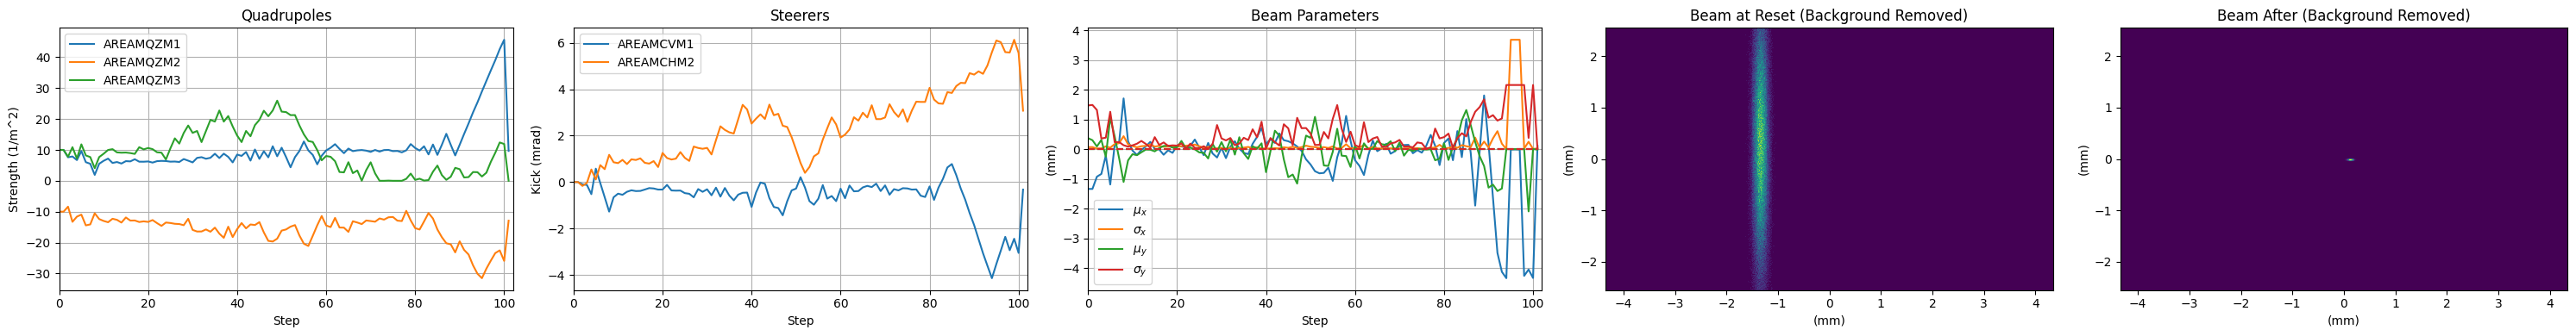

In [6]:
# hopefully this would run :)

optimize(
    target_mu_x=0.0,    # 0.4249e-3,
    target_sigma_x=0.0,
    target_mu_y=0.0,    # 1.1048e-3,
    target_sigma_y=0.0,
    target_mu_x_threshold=3.16e-6,
    target_mu_y_threshold=3.16e-6,
    target_sigma_x_threshold=3.16e-6,
    target_sigma_y_threshold=3.16e-6,
    max_steps=100,
    model_name="BO",
    logbook=True,
    callback=None,
    obj_function="logmae",
    acquisition="EI",
    init_x=None,
    init_samples=5,
    filter_action=None,
)


In [ ]:
# hopefully this would run :)

# optimize(
#     target_mu_x=0.4249e-3,
#     target_sigma_x=0.0,
#     target_mu_y=1.1048e-3,
#     target_sigma_y=0.0,
#     target_mu_x_threshold=3.16e-6,
#     target_mu_y_threshold=3.16e-6,
#     target_sigma_x_threshold=3.16e-6,
#     target_sigma_y_threshold=3.16e-6,
#     max_steps=100,
#     model_name="BO",
#     logbook=True,
#     callback=None,
#     obj_function='logmae',
#     acquisition="EI",
#     init_x = None,
#     init_samples = 5,
#     filter_action = None,
# )
